# Enefit - Predict Energy Behavior of Prosumers
<h4>Predict Prosumer Energy Patterns and Minimize Imbalance Costs:</h4>
<p>Your challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity.</p>

<b>Estonia: 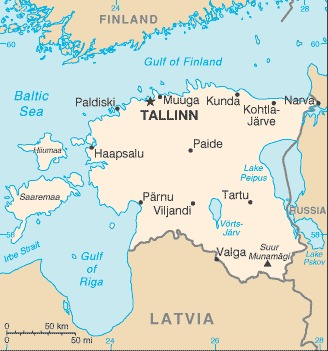 centroid = (26.0, 59.0) 

In [1]:
import json
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn
import statsmodels.api as sm

In [2]:
import geopandas as gpd

/Users/blcrosbie/dev/public/kaggle/predict-energy-behavior-of-prosumers/venv/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [4]:
import datetime
import pytz
import holidays
import optuna
import joblib

/Users/blcrosbie/dev/public/kaggle/predict-energy-behavior-of-prosumers/venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from typing import Optional,Dict,Tuple
from pathlib import Path

In [6]:
from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.solar_tracking import calculate_elevation_angle, calculate_irradiation_on_surface

In [11]:
# os.chdir('predict-energy-behavior-of-prosumers/')

plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi': 150})

### Load Files

In [12]:
INPUT_DIR = os.path.join(os.getcwd(), "input")

ESTONIA_GPKG = os.path.join(INPUT_DIR, "estonia.gpkg")

# Coordinate Reference System (CRS)
ESTONIA_CRS = "EPSG:4133"

In [13]:
# Read in all spatial layers
# boundary = gpd.read_file(ESTONIA_GPKG, layer='boundary', driver="GPKG", crs=ESTONIA_CRS)
counties = gpd.read_file(ESTONIA_GPKG, layer='counties', driver="GPKG", crs=ESTONIA_CRS)
# municipalities = gpd.read_file(ESTONIA_GPKG, layer='municipalities', driver="GPKG", crs=ESTONIA_CRS)
settlements = gpd.read_file(ESTONIA_GPKG, layer='settlements', driver="GPKG", crs=ESTONIA_CRS)
station = pd.read_csv(os.path.join(INPUT_DIR, 'weather_station_to_county_mapping.csv'))
dtypes={'latitude': 'float', 'longitude': 'float', 'county': 'int'}
station = station.dropna()
for col, dtype in dtypes.items():
    station[col] = station[col].astype(dtype)
    if dtype == 'float':
        station[col] = station[col].apply(lambda x: round(x, 1))
        
station_gdf = gpd.GeoDataFrame(
    station, geometry=gpd.points_from_xy(station.longitude, station.latitude), crs=ESTONIA_CRS
)

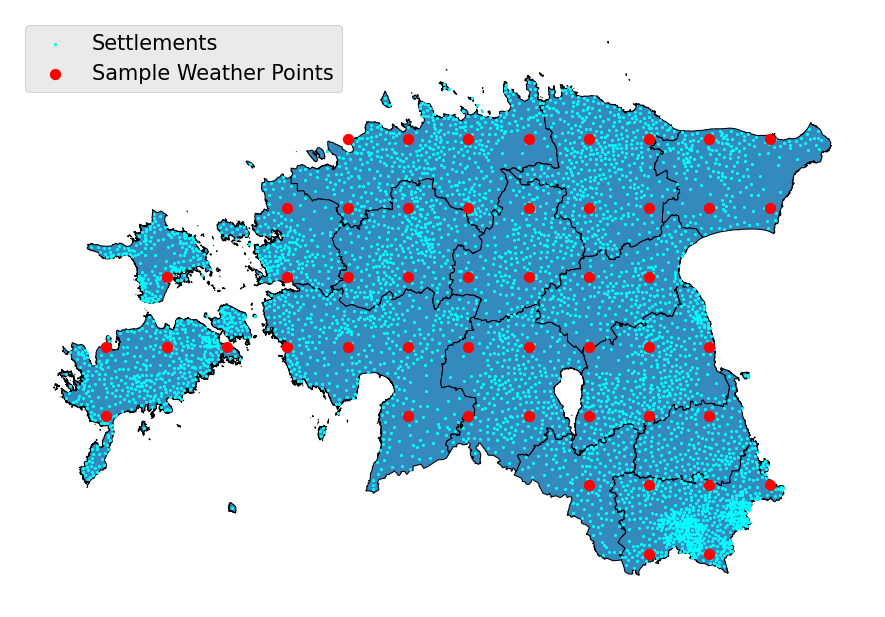

In [18]:
# Plot the counties of Estonia as well as the centroids of the Weather Data Sample Points
fig, ax = plt.subplots(figsize=(6,8))
counties.plot(edgecolor='k',ax=ax)
settlements.centroid.plot(markersize=1, color='cyan', ax=ax, label="Settlements")
station_gdf.centroid.plot(markersize=24,color='r', ax=ax, label="Sample Weather Points")
plt.legend()
plt.axis('off')
plt.tight_layout();

In [29]:
station_gdf

,county_name,longitude,latitude,county,geometry
10,Saaremaa,22.2,58.2,10,POINT (22.20000 58.20000)
11,Saaremaa,22.2,58.5,10,POINT (22.20000 58.50000)
19,Saaremaa,22.7,58.5,10,POINT (22.70000 58.50000)
20,Hiiumaa,22.7,58.8,1,POINT (22.70000 58.80000)
27,Saaremaa,23.2,58.5,10,POINT (23.20000 58.50000)
35,Pärnumaa,23.7,58.5,7,POINT (23.70000 58.50000)
36,Läänemaa,23.7,58.8,6,POINT (23.70000 58.80000)
37,Läänemaa,23.7,59.1,6,POINT (23.70000 59.10000)
43,Pärnumaa,24.2,58.5,7,POINT (24.20000 58.50000)
44,Raplamaa,24.2,58.8,9,POINT (24.20000 58.80000)


### Helper Functions for Handling Datetime

In [19]:
def bin_data(values, k, interval="equal"):
    """
    Given a list of values, 'k' bin
    return categorical bin group ids in specified intervals
    """
    min_val = values.min()
    max_val = values.max()
    
    binned_data = []
    thresholds = []
    
    if interval == "equal":
        intv = (max_val - min_val) / k
        thresholds = [i*intv for i in range(k)]
        
    elif interval == "stdev":
        intv = values.std()
        avg = values.mean()
        if k % 2 == 0:
            k_half = int(k/2)
            k_res = 0
        else:
            k_half = int((k-1)/2)
            k_res = 0.5
            
        for i in range(-1*k_half, k_half+1):
            if i == 0 and k_res == 0:
                pass
            else:
                thresholds.append((i*intv) + avg)

    elif interval == "equal_count":
        pass
        
    elif interval == "quantile":
        pass
    
    elif interval == "log_scale":
        pass

    else:
        pass
    

    binned_data = []
    for val in values:
        for j in range(0, len(thresholds)):
            if val < thresholds[j]:
                binned_data.append(j)
            else:
                pass
    
    return pd.Series(binned_data)
    
    


def extract_dt_attributes(df: pd.DataFrame):
    earliest_time = df.datetime.min()
    # convert datetime column, if not done already
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # dates and times
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')
    
    #
    df['year'] = df['datetime'].dt.year
    df['day_of_year'] = df['datetime'].dt.strftime('%j').astype(int)
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days
    
    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }
    
    for col in time_features:
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        else:
            df[col] = getattr(df['datetime'].dt,col)
        
        
        ## sin and cosine features to capture the circular continuity
        col_min,col_max = time_features[col]
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)
        
        # add sin and cos
        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')
    return df


def handle_timezone(dt: datetime):
    """
    https://www.timeanddate.com/time/change/estonia/tallinn
    """
    year = dt.year
    
    if year == 2021:
        
        if dt >= datetime.datetime.strptime("2021-10-31 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        else:
            utc_offset = 3
        
        
    elif year == 2022:
        
        if dt < datetime.datetime.strptime("2022-03-27 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        elif dt >= datetime.datetime.strptime("2022-10-30 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        else:
            utc_offset = 3
        
        
        
    elif year == 2023:
        
        if dt < datetime.datetime.strptime("2023-03-26 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
            
        elif dt >= datetime.datetime.strptime("2023-10-29 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        
        else:
            utc_offset = 3
        
        
    else:
        pass
    
    return utc_offset

def datetime_inference_attributes(dt: datetime):
    
    # dates and times
    date = dt.date
    time = dt.strftime('%H:%M:%S')

    year = dt.year
    day_of_year = dt.timetuple().tm_yday
    
    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }
    time_data = {}
    
    for key in time_features:
        if col=='week':
            time_data[key] = dt.isocalendar().week.astype(np.int32)
        else:
            time_data[key] = getattr(dt, key)
        
        
        ## sin and cosine features to capture the circular continuity
        key_min, key_max = time_features[key]
        angles = 2*np.pi*(time_data[key]-key_min)/(key_max-key_min+1)
        
        # add sin and cos
        time_data[f'{key}_sin'] = np.sin(angles).astype('float')
        time_data[f'{key}_cos'] = np.cos(angles).astype('float')
        
    time_data['date'] = date
    time_data['time'] = time
    time_data['year'] = year
    time_data['day_of_year'] = day_of_year
    return time_data

### Load the datasets

In [20]:
weather = pd.read_csv(os.path.join(INPUT_DIR, 'historical_weather.csv'), parse_dates=['datetime'], dtype={'data_block_id': 'int'})
forecast = pd.read_csv(os.path.join(INPUT_DIR,'forecast_weather.csv'), parse_dates=['origin_datetime', 'forecast_datetime'], dtype={'data_block_id': 'int'})

In [21]:
weather_gdf = gpd.GeoDataFrame(
    weather, geometry=gpd.points_from_xy(weather.longitude, weather.latitude), crs=ESTONIA_CRS
)

In [22]:
forecast_gdf = gpd.GeoDataFrame(
    forecast, geometry=gpd.points_from_xy(forecast.longitude, forecast.latitude), crs=ESTONIA_CRS
)

In [23]:
county_data = gpd.overlay(counties,\
                          weather_gdf,\
                          how='intersection',\
                          keep_geom_type=False\
)

In [24]:
county_pred = gpd.overlay(counties,\
                          forecast_gdf,\
                          how='intersection',\
                          keep_geom_type=False\
)

In [25]:
# weather_lookup = {}
# data_block_id_list = county_data.data_block_id.drop_duplicates().to_list()
# county_code_list = list(range(16))
# for dbid in data_block_id_list:
#     this_weather_block = county_data[county_data.data_block_id == dbid]
#     weather_lookup[dbid] = {}
#     for cty in county_code_list:
#         this_cty_weather = this_weather_block[this_weather_block.countyCodes == str(cty)].reset_index(drop=True)
#         cty_lookup = []
#         for rw in this_cty_weather.index:
#             this_cty_row = this_cty_weather.iloc[rw].to_dict()
#             cty_lookup.append(this_cty_row)
            
#         weather_lookup[dbid][cty] = cty_lookup

In [26]:
# forecast_lookup = {}
# data_block_id_list = county_pred.data_block_id.drop_duplicates().to_list()
# county_code_list = list(range(16))
# for dbid in data_block_id_list:
#     this_forecast_block = county_pred[county_pred.data_block_id == dbid]
#     forecast_lookup[dbid] = {}
#     for cty in county_code_list:
#         this_cty_forecast = this_forecast_block[this_forecast_block.countyCodes == str(cty)].reset_index(drop=True)
#         cty_lookup = []
#         for rw in this_cty_forecast.index:
#             this_cty_row = this_cty_forecast.iloc[rw].to_dict()
#             cty_lookup.append(this_cty_row)
            
#         forecast_lookup[dbid][cty] = cty_lookup

In [27]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'), parse_dates=['datetime'])

In [28]:
client_df = pd.read_csv(os.path.join(INPUT_DIR, 'client.csv'), parse_dates=['date'])

In [41]:
client_df

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
...,...,...,...,...,...,...,...
41914,1,15,51,415.60,0,2023-05-29,637
41915,3,15,161,2035.75,0,2023-05-29,637
41916,0,15,15,620.00,1,2023-05-29,637
41917,1,15,20,624.50,1,2023-05-29,637


In [46]:
client_lookup = client_df[client_df.data_block_id == 2][['county', 'is_business', 'product_type', 'installed_capacity']].groupby(by=['county', 'is_business', 'product_type']).agg({'installed_capacity': 'value_counts'})

In [50]:
client_lookup

installed_capacity
county is_business product_type installed_capacity                    
0      0           1            952.89                               1
                   2            166.40                               1
                   3            7207.88                              1
       1           0            400.00                               1
                   1            1411.00                              1
...                                                                ...
14     1           3            3114.60                              1
15     0           1            83.20                                1
                   3            918.20                               1
       1           1            325.00                               1
                   3            1778.70                              1

[61 rows x 1 columns]

In [ ]:
# with open('county_id_to_name_map.json', 'r') as fw:
#     county_lookup = json.load(fw)

In [ ]:
station_by_county = station
station_lookup = {}
for cty in station.county.drop_duplicates().to_list():
    this_cty = station[station.county == cty].reset_index(drop=True)
    this_cty_rows = []
    for rw in this_cty.index:
        this_cty_row = this_cty.iloc[rw].to_dict()
        this_cty_rows.append(this_cty_row)
        
    station_lookup[cty] = this_cty_rows

In [ ]:
electricity_df = pd.read_csv(os.path.join(INPUT_DIR, 'electricity_prices.csv'), parse_dates=['forecast_date', 'origin_date'])
gas_df = pd.read_csv(os.path.join(INPUT_DIR, 'gas_prices.csv'), parse_dates=['forecast_date', 'origin_date'])

### Emulate the Order of Operations based on the Input Fields given from API

In [ ]:
# known_columns = [
#     'county', 'is_business', 'product_type', 'is_consumption', 
#     'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'target'
# ]

# unknown_columns = ['row_id', 'target']

# input_df = train_df[known_columns]
# output_df = train_df[unknown_columns]
# # input_df = input_df.set_index('row_id')
# # output_df = output_df.set_index('row_id')

In [ ]:
# data_blocks = input_df.data_block_id.drop_duplicates().to_list()

In [ ]:
# train = {}
# for dbid in data_blocks:
#     api_data_block = input_df[input_df.data_block_id == dbid]
#     api_data_block = api_data_block.reset_index(drop=True)
#     data_block_list = []
#     for rw in api_data_block.index:
#         this_row_data = api_data_block.iloc[rw].to_dict()
#         data_block_list.append(this_row_data)
        
#     train[dbid] = data_block_list

    

#### 1. Handle Datetime
#### 2. Location -> Weather Reports + Forecast Information

In [ ]:
# test_count = 1
# for dbid, api_data in train.items():
#     dbid = 1
#     for row in api_data:
        
#         # Datetime Operations:
#         dt = row['datetime']
        
#         # Get UTC offset 
#         utc_offset = handle_timezone(dt)
#         row.update({'utc_offset': utc_offset})
        
#         # Get cyclic information and other datetime inferences
#         dt_inference = datetime_inference_attributes(dt)
#         row.update(dt_inference)
        
#         # Get Location
#         county = row['county']
#         #stations = station_lookup[county]
#         #station_ndx = 0
#         #for station in stations:
#         #    for k, v in station.items():
#         #        station_key = f'station_{k}_{station_ndx}'
#         #        row[station_key] = v
#         #    station_ndx += 1
            
#         # Get Weather History
#         print(dbid)
#         print(county)
#         if dbid in weather_lookup:
#             if county in weather_lookup[dbid]:
#                 this_weather = weather_lookup[dbid][county]
                
#                 station_ndx = 0
#                 for w in this_weather:
#                     for k, v in w.items():
#                         station_key = f'{k}_station_{station_ndx}'
#                         row[station_key] = v
#                     station_ndx += 1
#             else:
#                 pass
#         else:
#             pass
            
#         # Get Weather Forecast
#         if dbid in forecast_lookup:
#             if county in forecast_lookup[dbid]:
#                 this_forecast = forecast_lookup[dbid][county]
#                 station_ndx = 0
#                 for f in this_forecast:
#                     for k, v in f.items():
#                         station_key = f'{k}_station_{station_ndx}'
#                         row[station_key] = v
#                     station_ndx += 1
#             else:
#                 this_forecast = {}
#         else:
#             this_forecast = {}
        
            
            
            
#         for k, v in row.items():
#             print(k, v)
#         print(STOP)
        
        

    
#     test_count -= 1
#     if test_count == 0:
#         print(STOP)

In [ ]:
train_df = extract_dt_attributes(train_df)

### Visualize Solar Irradiance by County per Month

In [ ]:
# county_data['direct_solar_bin'] = bin_data(county_data['direct_solar_radiation'], k=6, interval="stdev")

In [ ]:
# for month in range(1, 13):

#     monthly_avg = county_data[(county_data.month == month) & (county_data.direct_solar_radiation > 0.0)].groupby(by=['countyCodes']).median()
#     monthly_max = county_data[(county_data.month == month) & (county_data.direct_solar_radiation > 0.0)].groupby(by=['countyCodes']).max()
#     monthly_avg = pd.merge(monthly_avg.reset_index(), counties, on='countyCodes')
#     monthly_max = pd.merge(monthly_max.reset_index(), counties, on='countyCodes')

#     fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

#     divider_0 = make_axes_locatable(ax[0])
#     divider_1 = make_axes_locatable(ax[1])

#     cax_0 = divider_0.append_axes("top", size="5%", pad=0.5)
#     cax_1 = divider_1.append_axes("bottom", size="5%", pad=0.5)

#     monthly_avg.plot(
#         column="direct_solar_radiation",
#         ax=ax[0],
#         legend=True,
#         cax=cax_0,
#         legend_kwds={"label": f"Nom Direct Solar Radiation: Month {month}", "orientation": "horizontal"},
#         cmap='OrRd'
#     );
#     monthly_max.plot(
#         column="direct_solar_radiation",
#         ax=ax[1],
#         legend=True,
#         cax=cax_1,
#         legend_kwds={"label": f"Max Direct Solar Radiation: Month {month}", "orientation": "horizontal"}
#     );
    
    
#     print("\n\n\n")

### Solar Production Analysis

In [ ]:
spa = train_df[train_df['is_consumption'] == 0]
spa = spa.rename(columns={'county': 'countyCodes'})
spa['countyCodes'] = spa['countyCodes'].astype(str)
spa = spa.set_index('countyCodes', 'datetime')
county_data['countyCodes'] = county_data['countyCodes'].astype(str)
county_weather_data = county_data.set_index('countyCodes', 'datetime')
spa = pd.merge(spa, county_weather_data, on=['countyCodes', 'datetime'])

In [ ]:
client_df

In [ ]:
filter_columns_spa = ['countyCodes', 'datetime', 'is_business', 'product_type', 'prediction_unit_id', 'target', 
                      'direct_solar_radiation', 'diffuse_radiation', 'shortwave_radiation',
                      'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total',
                      'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
                      'dayofweek', 'dayofweek_sine', 'dayofweek_cosine', 'week', 'week_sine', 'week_cosine',
                      'month', 'month_sine', 'month_cosine', 'day_of_year', 'latitude', 'longitude']

x_columns = [col for col in filter_columns_spa if col != "target"]
y_columns = ["target"]
spa = spa.reset_index()
spa = spa[filter_columns_spa]
spa

In [ ]:
spa['elevation'] = spa[['datetime', 'day_of_year', 'longitude', 'latitude']].apply(
    lambda x: calculate_elevation_angle(
        local_time=x[0], day_of_year=x[1], longitude=x[2], latitude=x[3], utc_offset=2
    ), axis=1
)

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(spa.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [ ]:
spa.product_type.value_counts()

In [ ]:
X = spa[x_columns]
del X['datetime']
y = spa[y_columns]

In [ ]:
X_business = X[X.is_business == 1]
X_consumer = X[X.is_business == 0]

In [ ]:
X_business.product_type.value_counts()

In [ ]:
X_consumer.product_type.value_counts()

In [ ]:
category_columns = ['countyCodes', 'is_business', 'product_type', 'prediction_unit_id']


for col in category_columns:
    X[col] = X[col].astype('category')
    del X[col]
X.dtypes

In [ ]:
y = y.fillna(0)

In [ ]:
def fit_model(
    X:pd.DataFrame,
    y:pd.Series,
    config:Optional[Dict]=None,
    n_jobs:int=1,
) -> XGBRegressor:
    '''
    Train a xgboost regressor with L1 loss
    '''
    model = XGBRegressor(
        objective='reg:absoluteerror',
        tree_method='hist',
        n_jobs=n_jobs,
        enable_categorical=True,
        base_score=y.mean()
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
    
    return model.fit(X,y)

In [ ]:
model_1 = XGBRegressor()
# model_1.enable_categorical = True
model_1.fit(X, y)

In [ ]:
test_ndx = 3593933
y_hat = []
for ndx in X.index:
    test_row = np.asarray([X.iloc[ndx]])
    pred_val = model_1.predict(test_row)
    y_hat.append(pred_val)
    
# actual_val = y.iloc[test_ndx]

# make a prediction
# yhat = model_1.predict(test_row)

# summarize prediction
# print('Predicted: %.3f' % yhat)
# print('Actual: %.3f' % actual_val)

In [ ]:
times = spa.datetime.to_list()
plt.plot(times, y.target.to_list(), 'b', linewidth=0.3)
plt.plot(times, y_hat, 'o', linewidth=0.3)

In [ ]:
# counts for the country,store,product
desc_columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(desc_columns), figsize=(5*len(desc_columns), 3))

for i, column in enumerate(desc_columns):
    _ = sns.countplot(train_df, x=column, ax=axs[i])

_ = fig.tight_layout()

In [ ]:
train_avgd = (
    train_df
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

In [ ]:
# plot of average weekly sales
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

In [ ]:
# get train attributes
extract_dt_attributes(train_df)

In [ ]:
categorical_cols = ['county', 'product_type']
for column in categorical_cols:
    train_df[column] = train_df[column].astype('category')

In [ ]:
train_df[train_df['is_consumption'] == 0][['target', 'hour', 'month']].groupby(by=['month', 'hour']).mean()

In [ ]:
client_df[(client_df.data_block_id == 4) & (client_df.county == 0)]

In [ ]:
train_df[(train_df.data_block_id == 1) & (train_df.county == 0)]

In [ ]:
print(f"Total Observed Hours: {len(train_df.datetime.drop_duplicates().to_list())}")
print(f"Counties: {len(train_df.county.drop_duplicates().to_list())}")
print(f"Prediction Types: {len(train_df.prediction_unit_id.drop_duplicates().to_list())}")
print(f"Data Blocks: {len(train_df.data_block_id.drop_duplicates().to_list())}")

<h4>Business</h4|>

In [ ]:
for county_id in train_df.county.drop_duplicates().to_list()[0:1]:
    county_df = train_df[train_df.county == county_id]
    for product_type in county_df.product_type.drop_duplicates().to_list()[0:1]:
        cpt_df = county_df[county_df.product_type == product_type]
        consumed_df = cpt_df[(cpt_df.is_business == 1) & (cpt_df.is_consumption == 1)]
        print(consumed_df.sort_values('datetime', ascending=True))
        x = range(len(consumed_df))
        y = consumed_df.target.to_list()
        plt.plot(x, y)
        plt.show()



<h4>Consumer</h4>

In [ ]:
for county_id in train_df.county.drop_duplicates().to_list()[0:1]:
    county_df = train_df[train_df.county == county_id]
    for product_type in county_df.product_type.drop_duplicates().to_list():
        cpt_df = county_df[county_df.product_type == product_type]
        non_biz_cpt_df = cpt_df[cpt_df.is_business == 0]
        print(non_biz_cpt_df)